## Tibetan convective systems 

Script to filter out only convective cells which are (at least partly) over the TP 





In [28]:
import numpy as np 
import xarray as xr 
import pandas as pd
import warnings
import os 
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [78]:
# read in example tracks 
savedir= '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking' 
tracks = pd.read_hdf(savedir + '/Tracks_tbb_2004_heavyraincorefiltered.h5', 'table')

In [81]:
tracks.shape

(6279, 14)

In [82]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells,cell,time_cell
42468,7140,1285,16.698690,426.574577,126,210,10962,2004-04-27 18:30:00,2004-04-27 18:30:00,16.619869,102.707458,433,24320.0,0 days 00:00:00
42474,7141,1286,15.703293,427.838156,146,210,10968,2004-04-27 19:00:00,2004-04-27 19:00:00,16.520329,102.833814,450,24320.0,0 days 00:30:00
42480,7142,1287,15.797317,427.870918,145,205,10974,2004-04-27 19:30:00,2004-04-27 19:30:00,16.529731,102.837090,998,24320.0,0 days 01:00:00
42485,7143,1288,16.522365,427.647781,102,200,10979,2004-04-27 20:00:00,2004-04-27 20:00:00,16.602236,102.814777,1178,24320.0,0 days 01:30:00
42489,7144,1289,17.302799,427.006249,105,200,10983,2004-04-27 20:30:00,2004-04-27 20:30:00,16.680280,102.750625,1239,24320.0,0 days 02:00:00
42494,7145,1290,17.738634,427.867770,250,205,10988,2004-04-27 21:00:00,2004-04-27 21:00:00,16.723863,102.836776,816,24320.0,0 days 02:30:00
42497,7146,1291,18.268007,427.356271,188,205,10991,2004-04-27 21:30:00,2004-04-27 21:30:00,16.776801,102.785627,910,24320.0,0 days 03:00:00
42503,7147,1292,17.480166,427.521401,102,205,10997,2004-04-27 22:00:00,2004-04-27 22:00:00,16.698016,102.802139,1029,24320.0,0 days 03:30:00
42509,7148,1293,17.145971,429.965983,160,210,11003,2004-04-27 22:30:00,2004-04-27 22:30:00,16.664597,103.046601,1256,24320.0,0 days 04:00:00
42517,7149,1294,17.452594,430.844357,225,215,11011,2004-04-27 23:00:00,2004-04-27 23:00:00,16.695259,103.134437,1113,24320.0,0 days 04:30:00


In [83]:
## elevation mask 

dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
 
# mask as coordinates 
dem_mask = elevations.where(elevations >= 3000)
dem_mask.coords['mask'] = (('lon', 'lat'), dem_mask)



In [86]:
removed = 0 
tracks['tp_flag'] = 0 

# loop through cells 
for cell in np.unique(tracks.cell.values):
    subset = tracks[tracks.cell == cell]
    print('checking heavy rain cores for cell:', cell, subset.shape)
    tp_flag = 0 
    # loop through timesteps of features for specific cell 
    for idx in subset.idx.values: 
        # idx is the timestep index for respective timestep or mask file 
    
        # open corresponding precip and mask file 
        year = subset.time.values[0].year 
        month = subset.time.values[0].month
        if len(str(month))== 1: 
            month= '0' + str(month)
            
        # check whether segmented feature is in area above 3000 m 
        maskfile = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Mask_Segmentation_'+str(year) + str(month) + '.nc'
        mask = xr.open_dataarray(maskfile)
        mask= mask[:,1:,1:].T
        
        # get right timestep frames 
        seg= mask[:,:,idx]

        # get feature ID for frame 
        featureid= subset.feature[subset.idx== idx].values[0]
        
        # create mask as coordinates 
        seg_mask = seg.where(seg == featureid)
        seg_mask.coords['mask'] = (('lon', 'lat'), seg_mask)
        # apply mask on precip data to extract precip values for feature in cell 
        elevation_values = dem_mask.where(seg_mask.coords['mask'].values > 1)
        arr= elevation_values.values.flatten()
        values = arr[~np.isnan(arr)]
        mountain_features = values[values >=3000].shape[0]
                
        if mountain_features >= 10: 
            tp_flag += mountain_features
            # percentage of area which lies within TP boundary 
            percentage= tp_flag / tracks[tracks.feature == featureid].ncells.values[0]
            tracks['tp_flag'][tracks.feature == featureid] =  percentage

            
            
    if tp_flag ==  0: 
        # remove corresponding cell from track dataframe 
        tracks = tracks.drop(tracks[tracks.cell == cell].index)
        print(cell, ' removed, because it is outside of the 3000 m boundary.')
        removed += 1 
    else:
        print('cell is over TP:  ', cell)
    
    
    
tracks.to_hdf(os.path.join(savedir,'Tracks_2004_TPflag.h5'),'table')    

checking heavy rain cores for cell: 24320.0 (13, 15)
24320.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24839.0 (10, 15)
24839.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24872.0 (8, 15)
24872.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24874.0 (18, 15)
24874.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24936.0 (15, 15)
24936.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24979.0 (15, 15)
24979.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25322.0 (17, 15)
25322.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25534.0 (15, 15)
25534.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25639.0 (15, 15)
25639.0  rem

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   26465.0
checking heavy rain cores for cell: 26543.0 (10, 15)
26543.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26583.0 (16, 15)
26583.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26609.0 (10, 15)
26609.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26621.0 (16, 15)
26621.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26648.0 (22, 15)
26648.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26675.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   26675.0
checking heavy rain cores for cell: 26709.0 (12, 15)
26709.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26739.0 (10, 15)
26739.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26766.0 (10, 15)
26766.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26792.0 (21, 15)
26792.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26812.0 (8, 15)
26812.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26875.0 (9, 15)
26875.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26886.0 (10, 15)
26886.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26908.0 (14, 15)
26908.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 269

30093.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30135.0 (14, 15)
30135.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30143.0 (20, 15)
30143.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30154.0 (11, 15)
30154.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30174.0 (12, 15)
30174.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30212.0 (13, 15)
30212.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30263.0 (15, 15)
30263.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30272.0 (14, 15)
30272.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30281.0 (12, 15)
30281.0  removed, because it is outside of the 3000 m boundary.


32454.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32525.0 (20, 15)
32525.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32605.0 (9, 15)
32605.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32718.0 (14, 15)
32718.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32736.0 (16, 15)
32736.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32842.0 (7, 15)
32842.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32852.0 (11, 15)
32852.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32859.0 (7, 15)
32859.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32922.0 (10, 15)
32922.0  removed, because it is outside of the 3000 m boundary.
che

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   33769.0
checking heavy rain cores for cell: 33786.0 (26, 15)
33786.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 33813.0 (14, 15)
33813.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34038.0 (13, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   34038.0
checking heavy rain cores for cell: 34041.0 (8, 15)
34041.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34154.0 (13, 15)
34154.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34170.0 (25, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34170.0
checking heavy rain cores for cell: 34305.0 (12, 15)
34305.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34364.0 (10, 15)
34364.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34397.0 (11, 15)
34397.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34459.0 (10, 15)
34459.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34500.0 (11, 15)
34500.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34528.0 (8, 15)
34528.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34538.0 (15, 15)
34538.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34546.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34546.0
checking heavy rain cores for cell: 34581.0 (13, 15)
34581.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34706.0 (8, 15)
34706.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34731.0 (21, 15)
34731.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34810.0 (17, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34810.0
checking heavy rain cores for cell: 34955.0 (15, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34955.0
checking heavy rain cores for cell: 35188.0 (13, 15)
35188.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35486.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   35486.0
checking heavy rain cores for cell: 35537.0 (25, 15)
35537.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35552.0 (16, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   35552.0
checking heavy rain cores for cell: 35709.0 (15, 15)
35709.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35784.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   35784.0
checking heavy rain cores for cell: 35897.0 (7, 15)
35897.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35938.0 (8, 15)
35938.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35957.0 (15, 15)
35957.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35974.0 (12, 15)
35974.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36203.0 (8, 15)
36203.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36275.0 (12, 15)
36275.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36371.0 (7, 15)
36371.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36393.0 (8, 15)
36393.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36596.

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   37675.0
checking heavy rain cores for cell: 37724.0 (18, 15)
37724.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37796.0 (20, 15)
37796.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37809.0 (8, 15)
37809.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37861.0 (20, 15)
37861.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38008.0 (14, 15)
38008.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38032.0 (11, 15)
38032.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38040.0 (10, 15)
38040.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38056.0 (7, 15)
38056.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 380

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   39860.0
checking heavy rain cores for cell: 39903.0 (12, 15)
39903.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 39910.0 (17, 15)
39910.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 39982.0 (23, 15)
39982.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40173.0 (9, 15)
40173.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40272.0 (16, 15)
40272.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40318.0 (12, 15)
40318.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40394.0 (10, 15)
40394.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40426.0 (13, 15)
40426.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   41450.0
checking heavy rain cores for cell: 41584.0 (14, 15)
41584.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41831.0 (21, 15)
41831.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41856.0 (10, 15)
41856.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41904.0 (9, 15)
41904.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41970.0 (8, 15)
41970.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42222.0 (9, 15)
42222.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42262.0 (7, 15)
42262.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42291.0 (18, 15)
42291.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42298

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   45205.0
checking heavy rain cores for cell: 45285.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45285.0
checking heavy rain cores for cell: 45419.0 (7, 15)
45419.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45457.0 (15, 15)
45457.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45486.0 (8, 15)
45486.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45644.0 (17, 15)
45644.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45657.0 (7, 15)
45657.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45936.0 (26, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45936.0
checking heavy rain cores for cell: 45945.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45945.0
checking heavy rain cores for cell: 45981.0 (13, 15)
45981.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46030.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46030.0
checking heavy rain cores for cell: 46040.0 (19, 15)
46040.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46103.0 (17, 15)
46103.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46166.0 (7, 15)
46166.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46208.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46208.0
checking heavy rain cores for cell: 46212.0 (24, 15)
46212.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46240.0 (8, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46240.0
checking heavy rain cores for cell: 46243.0 (21, 15)
46243.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46285.0 (8, 15)
46285.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46304.0 (9, 15)
46304.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46313.0 (10, 15)
46313.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46327.0 (12, 15)
46327.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46336.0 (23, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46336.0
checking heavy rain cores for cell: 46383.0 (18, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46383.0
checking heavy rain cores for cell: 46391.0 (8, 15)
46391.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46446.0 (43, 15)
46446.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46551.0 (7, 15)
46551.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46569.0 (42, 15)
46569.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46789.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   46789.0
checking heavy rain cores for cell: 46808.0 (8, 15)
46808.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46963.0 (16, 15)
46963.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46966.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46966.0
checking heavy rain cores for cell: 46998.0 (11, 15)
46998.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47116.0 (15, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   47116.0
checking heavy rain cores for cell: 47235.0 (26, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47235.0
checking heavy rain cores for cell: 47287.0 (21, 15)
47287.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47295.0 (8, 15)
47295.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47358.0 (8, 15)
47358.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47580.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47580.0
checking heavy rain cores for cell: 47699.0 (16, 15)
47699.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47703.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47703.0
checking heavy rain cores for cell: 47771.0 (12, 15)
47771.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47867.0 (7, 15)
47867.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47928.0 (35, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47928.0
checking heavy rain cores for cell: 48157.0 (18, 15)
48157.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48158.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   48158.0
checking heavy rain cores for cell: 48336.0 (14, 15)
48336.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48337.0 (10, 15)
48337.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48371.0 (30, 15)
48371.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48600.0 (9, 15)
48600.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48626.0 (18, 15)
48626.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48746.0 (9, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   48746.0
checking heavy rain cores for cell: 48770.0 (10, 15)
48770.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48870.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   48870.0
checking heavy rain cores for cell: 48892.0 (9, 15)
48892.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48945.0 (12, 15)
48945.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48959.0 (17, 15)
48959.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49003.0 (15, 15)
49003.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49082.0 (9, 15)
49082.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49172.0 (14, 15)
49172.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49186.0 (17, 15)
49186.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49255.0 (11, 15)
49255.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 492

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   51765.0
checking heavy rain cores for cell: 51797.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   51797.0
checking heavy rain cores for cell: 51813.0 (18, 15)
51813.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51829.0 (8, 15)
51829.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51830.0 (22, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   51830.0
checking heavy rain cores for cell: 51975.0 (8, 15)
51975.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51985.0 (11, 15)
51985.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52113.0 (20, 15)
52113.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52123.0 (7, 15)
52123.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52129.0 (14, 15)
52129.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52147.0 (35, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   52147.0
checking heavy rain cores for cell: 53142.0 (72, 15)
53142.0  removed, because it is outside of the 3000 m boundary.


/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['time', 'timestr']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Example for Tibetan convective system : step-by-step plot

In [120]:
tracks[tracks.cell== 46336.0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells,cell,time_cell,tp_flag
121123,12988,1277,119.488823,262.677871,127,220,19717,2004-08-27 14:30:00,2004-08-27 14:30:00,26.898883,86.317786,297,46336.0,00:00:00,37
121140,12989,1278,119.676425,263.162668,120,215,19734,2004-08-27 15:00:00,2004-08-27 15:00:00,26.917643,86.366265,313,46336.0,00:30:00,65
121159,12990,1279,119.517083,263.438322,122,210,19753,2004-08-27 15:30:00,2004-08-27 15:30:00,26.901709,86.393830,517,46336.0,01:00:00,100
121179,12991,1280,119.593042,264.028922,134,210,19773,2004-08-27 16:00:00,2004-08-27 16:00:00,26.909305,86.452889,469,46336.0,01:30:00,146
121198,12992,1281,119.111343,265.073317,106,205,19792,2004-08-27 16:30:00,2004-08-27 16:30:00,26.861135,86.557335,519,46336.0,02:00:00,210
121215,12993,1282,118.658374,267.489735,142,205,19809,2004-08-27 17:00:00,2004-08-27 17:00:00,26.815838,86.798973,565,46336.0,02:30:00,286
121232,12994,1283,117.697293,270.470951,172,205,19826,2004-08-27 17:30:00,2004-08-27 17:30:00,26.719729,87.097097,751,46336.0,03:00:00,375
121248,12995,1284,116.403955,272.394735,151,205,19842,2004-08-27 18:00:00,2004-08-27 18:00:00,26.590395,87.289473,937,46336.0,03:30:00,476
121264,12996,1285,116.375049,273.220784,132,205,19858,2004-08-27 18:30:00,2004-08-27 18:30:00,26.587504,87.372077,951,46336.0,04:00:00,583
121280,12997,1286,116.793548,275.373568,169,205,19874,2004-08-27 19:00:00,2004-08-27 19:00:00,26.629354,87.587359,768,46336.0,04:30:00,688


In [112]:
for feature in np.unique(tracks.feature.values):
    if tracks[tracks.feature == feature].ncells.values[0] == tracks[tracks.feature == feature].tp_flag.values[0]:
        print(feature)
    #else:
        #print('only percentage:',tracks[tracks.feature == feature].ncells.values[0]/  tracks[tracks.feature == feature].tp_flag.values[0] )

19992


In [98]:
for cell in np.unique(tracks.cell.values):
    subset= tracks[tracks.cell == cell ]
    if subset.tp_flag.values[0]> 0:
        print(cell, subset.shape[0]*0.5)

34038.0 6.5
34546.0 7.0
35552.0 8.0
37675.0 4.0
39860.0 8.5
45936.0 13.0
45945.0 7.0
46208.0 3.5
46240.0 4.0
46336.0 11.5
46383.0 9.0
46966.0 3.5
47116.0 7.5
47235.0 13.0
47580.0 7.0
47703.0 9.5
47928.0 17.5
48746.0 4.5
51765.0 5.0
51830.0 11.0


In [127]:
## Import elevation file for 3000 m boundary 
import xarray 

dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
elevations.dims




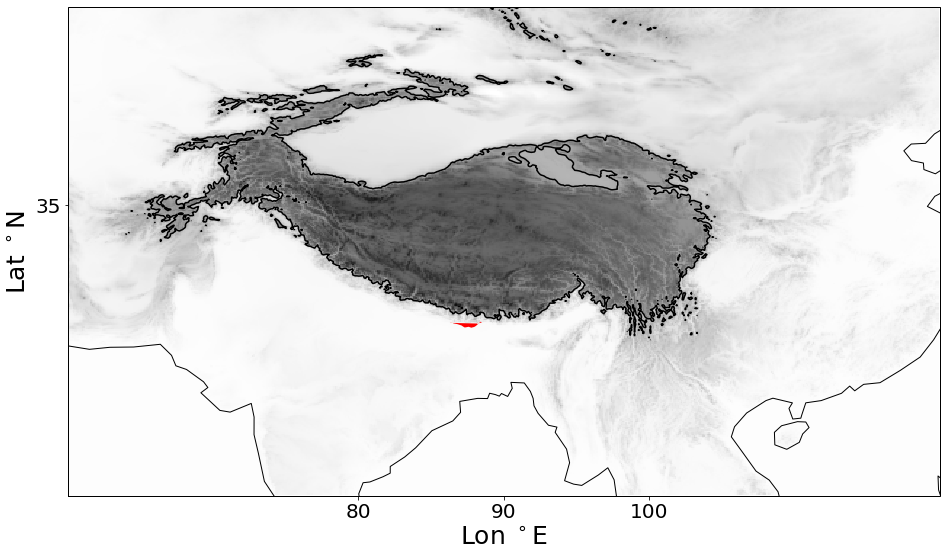

In [174]:
# plot background DEM 
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

plt.figure(figsize=(20,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([60,120,15,45])

# 3000 m boundary 
ax.contour(elevations.lon.values,elevations.lat.values, elevations.values.T, [3000], cmap = 'Greys_r')

cmap=plt.cm.viridis

m = ax.pcolormesh(elevations.lon.values,elevations.lat.values, elevations.values.T, cmap = 'Greys')



# plot track 
storm= tracks[tracks.cell == 46336]
track = sgeom.LineString(zip(storm.longitude.values, storm.latitude.values))

ax.add_geometries([track], ccrs.PlateCarree(),facecolor='red')

xlabels=[80,90,100]
ylabels= [35]
plt.xticks(xlabels, xlabels, fontsize=20)
plt.yticks(ylabels,ylabels, fontsize=20)
plt.xlabel('Lon $^\circ$E',  fontsize=25)
plt.ylabel('Lat $^\circ$N',  fontsize=25)


ax.coastlines()

#cbar= plt.colorbar(m, extend = 'max')
#cbar.set_ticks([240,250,260,270,280,290,300])
#cbar.set_label('elevation (m)', fontsize = 15)

plt.savefig('example_track_2004.png')
plt.show()


# plot track 




# subplot with initiation, majurity and dissipation 


